# Lab3. Amazon SageMaker DeepAR

This notebook shows how to apply the SageMaker [DeepAR built-in algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html). DeepAR forecasting algorithm is a supervised learning algorithm for forecasting scalar (one-dimensional) time series using recurrent neural networks (RNN) to produce both point and probabilistic forecasts.The DeepAR forecasting algorithm can provide better forecast accuracies compared to classical forecasting techniques such as Autoregressive Integrated Moving Average (ARIMA) or Exponential Smoothing (ES), both of which are implemented in many open-source and commercial software packages for forecasting. 

## Table Of Contents
The overall process for this is:

1. Setup
1. Data Preparation
1. Training the DeepAR Model
1. Prediction
1. Plotting the Prediction

To get started, simply execute the cells below:

## 1. Setup 

We use variables and dataframes that we stored in Lab1. Please make sure you already finished 1st step.
- [1.Exploratory_Data_Analysis.ipynb](1.Exploratory_Data_Analysis.ipynb)  


In [1]:
%store -r

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 2. Data Preparation

We will divide our clikstream events by page so that each page has its own clickstream timesereis.

**Note**
> If you went through the [3rd Hands on Lab](../3_Automate_sales_projections_with_Amazon_Forecast/README.md) of Amazon forecast service. You may consider the pages as products (SKU) sold in retail store.  
> If we use Amazon Forecast, page click data will be target timeseries and other series (users, urls) will be related timesreies. 

We will predict the number of clicks in 10 minutes by referring to the number of visitors. To do this, we use the number of clicks as the target feature and the number of users as the dynamic feature.

Change the data to the format that DeepAR algorithm use. The records in your input files should contain the following fields:

* **start** : The start timestamp. A string with the format YYYY-MM-DD HH:MM:SS.
* **target** : An array of floating-point values or integers that represent the time series. Here, we will use clickstream counts in 10 minutes for forecasting value.
* **dynamic_feat (optional)** : An array of arrays of floating-point values or integers that represents the vector of custom feature time series. Here, we will use the number of visitors in 10 minutes for dynamic features.
* **cat (optional)** : An array of categorical features that can be used to encode the groups that the record belongs to. We do not use categorical values in this example.

```python
# example:
{"start": "2012-03-01 00:00:00", "target": [24.0, 22.0, 20.0, 17.0, ...], "dynamic_feat": [[13, 14, 8, ...]]}
```

For more information regarding input/outpot format of DeepAR : https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html#deepar-inputoutput


In [3]:
training_data = []
for index, url in zip(range(len(urls)), urls):
    agg_click_users = filtered_clickstream[filtered_clickstream['url'] == url].set_index('timestamp').resample('10T')
    clicks = agg_click_users.sum()['clickstream_id']
    users  = agg_click_users.nunique()['user_session_id']
    
    data = {'start' : str(agg_click_users.nunique().index[0]),
            'target': list(clicks.values.astype('float')),
            'dynamic_feat': [list(users.values.astype('float'))]
            }
    training_data.append(data)   

We convert the dict type above into a json file.  
Write training and test files in JSON Lines, and upload to S3:

In [4]:
import json

def write_dicts_to_file(path, data):
    with open(path, 'wb') as fp:
        for row in training_data:
            fp.write(json.dumps(row).encode("utf-8"))
            fp.write("\n".encode('utf-8'))
            
write_dicts_to_file("train.json", training_data)

In [5]:
import sagemaker

sagemaker_session = sagemaker.Session()
s3_bucket = sagemaker.Session().default_bucket()  # replace with an existing bucket if needed
s3_prefix = 'deepar-clickstream'    # prefix used for all data stored within the bucket

role = sagemaker.get_execution_role()             # IAM role to use by SageMaker

train_s3 = sagemaker_session.upload_data(path='train.json', key_prefix=s3_prefix)
train_s3

's3://sagemaker-us-east-1-308961792850/deepar-clickstream/train.json'

Check the status of the upload by skiming the uploaded file.

In [6]:
import s3fs

s3filesystem = s3fs.S3FileSystem()
with s3filesystem.open(train_s3, 'rb') as fp:
    print(fp.readline().decode("utf-8")[:100] + "...")

{"start": "2012-03-01 00:00:00", "target": [24.0, 22.0, 20.0, 17.0, 15.0, 12.0, 15.0, 10.0, 14.0, 9....


## 3. Training the DeepAR Model

Just like other built-in algorithms, we need to define Estimator with algorhtim and hyperparameters and fit the model with the training data that we prepared above.

We are using the [Python SageMaker SDK](https://sagemaker.readthedocs.io/en/stable/index.html) to:

1. Create our [Estimator](https://sagemaker.readthedocs.io/en/stable/estimators.html) defining the algorithm and fitting/hyper-parameters
2. Define our [data channels](https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms-training-algo-running-container.html#your-algorithms-training-algo-running-container-inputdataconfig) to fit and validate on
3. [Fit](https://sagemaker.readthedocs.io/en/stable/estimators.html#sagemaker.estimator.Estimator.fit) a model to the data

In [7]:
import datetime 

region = sagemaker_session.boto_region_name

# we use 10 minutes frequency for the time series
freq = datetime.timedelta(minutes=10)

# we predict for 24 hours and use same context length with prediction length.
prediction_length = 24 * 6
context_length = 24 * 6

image_name = sagemaker.amazon.amazon_estimator.get_image_uri(region, "forecasting-deepar", "latest")

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [8]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    base_job_name='deepar-clickstream'
)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


Next, we need to set some hyperparameters. Some of them are related to the algorithm and some others are related to the training job. 
- `time_freq` : The granularity of the time series in the dataset. (M, W, D, H, min, ...)
- `context_length` : The number of time-points that the model gets to see before making the prediction. 
- `prediction_length` : The number of time-steps that the model is trained to predict (forecast horizon)
- `num_dynamic_feat` : The number of dynamic_feat provided in the data (default:`auto`) 
- `epochs` : The maximum number of passes over the training data
- `early_stopping_patience` : Training stops when no progress is made within the specified number of `epochs`.
- `mini_batch_size` : The size of mini-batches used during training
- `learning_rate` : The learning rate used in training

For more information, refer to the [DeepAR document](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_hyperparameters.html)

In [9]:
hyperparameters = {
    "time_freq": '10min',
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_dynamic_feat" : "auto",
    "epochs": "400",
    "early_stopping_patience": "40",
    "mini_batch_size": "64",
    "learning_rate": "5E-4"
}
estimator.set_hyperparameters(**hyperparameters)

We are ready to launch the training job. SageMaker will start an EC2 instance, download the data from S3, start training the model and save the trained model. Training will take about 20 minutes in c4.2xlarge instance.

In [10]:
%%time
data_channels = {
    "train": train_s3
}

estimator.fit(data_channels, wait=False)

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


CPU times: user 12.2 ms, sys: 5 µs, total: 12.2 ms
Wall time: 217 ms


In [11]:
sagemaker_session.logs_for_job(estimator.latest_training_job.name, wait=True)

2020-10-04 07:33:17 Starting - Starting the training job...
2020-10-04 07:33:18 Starting - Launching requested ML instances......
2020-10-04 07:34:22 Starting - Preparing the instances for training...
2020-10-04 07:35:09 Downloading - Downloading input data...
2020-10-04 07:35:31 Training - Downloading the training image.Arguments: train
[10/04/2020 07:35:53 INFO 139662618720064] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[10/04/2020 07:35:53 IN

## 4. Prediction

When deploying trained model to SageMaker endpoint, we will pass below utility class together: this allows to return a dcitionary encoding for requests using pandas.Series objects rather than raw JSON strings.

In generel, you may copy this code to your system but slightly change some numbsers such as time delta, prediction lengths, etc. For more information, you can refer to the [RealTimePredictor in SageMaker SDK](https://sagemaker.readthedocs.io/en/v1.2.3/predictors.html) which is the parent of this utility class.

In [12]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, content_type=sagemaker.content_types.CONTENT_TYPE_JSON, **kwargs)
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                num_samples=100, return_samples=False, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        ts -- `pandas.Series` object, the time series to predict
        cat -- integer, the group associated to the time series (default: None)
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        return_samples -- boolean indicating whether to include samples in the response (default: False)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_time = ts.index[-1] + datetime.timedelta(minutes=10)
#         prediction_time = 144
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)
    
    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None)

        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles
        }
        
        http_request_data = {
            "instances": [instance],
            "configuration": configuration
        }
        
        return json.dumps(http_request_data).encode('utf-8')
    
    def __decode_response(self, response, freq, prediction_time, return_samples):
        # we only sent one time series so we only receive one in return
        # however, if possible one will pass multiple time series as predictions will then be faster
        predictions = json.loads(response.decode('utf-8'))['predictions'][0]
        prediction_length = len(next(iter(predictions['quantiles'].values())))
        
        prediction_index = pd.date_range(prediction_time, prediction_time + freq * (prediction_length-1), freq=freq)
        
        if return_samples:
            dict_of_samples = {'sample_' + str(i): s for i, s in enumerate(predictions['samples'])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(data={**predictions['quantiles'], **dict_of_samples}, index=prediction_index)

    def set_frequency(self, freq):
        self.freq = freq
        
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]        

def series_to_dict(ts, cat=None, dynamic_feat=None):
    """Given a pandas.Series object, returns a dictionary encoding the time series.

    ts -- a pands.Series object with the target time series
    cat -- an integer indicating the time series category

    Return value: a dictionary
    """
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat        
    return obj

Now let's deploy the model with below code. 

In [13]:
# predictor.delete_endpoint()
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    predictor_cls=DeepARPredictor, 
    wait=True)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-------------!

Pass the test dataset in CSV format to the inference endpoint. Note that the serializer and deserializer will automatically take care of the datatype conversion from Numpy NDArrays.

In [14]:
test_data = pd.Series(training_data[0]['target'][:-144])
test_data.index=pd.date_range(training_data[0]['start'], 
                              datetime.datetime.strptime(training_data[0]['start'],'%Y-%m-%d %H:%M:%S')+datetime.timedelta(minutes=10*2015), 
                              freq='10T')
test_data

2012-03-01 00:00:00    24.0
2012-03-01 00:10:00    22.0
2012-03-01 00:20:00    20.0
2012-03-01 00:30:00    17.0
2012-03-01 00:40:00    15.0
                       ... 
2012-03-14 23:10:00    60.0
2012-03-14 23:20:00    60.0
2012-03-14 23:30:00    38.0
2012-03-14 23:40:00    36.0
2012-03-14 23:50:00    29.0
Freq: 10T, Length: 2016, dtype: float64

In [15]:
prediction = predictor.predict(ts=test_data, 
                               dynamic_feat=training_data[0]['dynamic_feat'],
                               quantiles=[0.10, 0.5, 0.90])
prediction

,0.1,0.9,0.5
2012-03-15 00:00:00,17.826349,28.005518,23.360205
2012-03-15 00:10:00,13.563330,21.258057,17.840389
2012-03-15 00:20:00,9.901986,17.281578,13.462849
2012-03-15 00:30:00,6.711700,14.006804,10.369482
2012-03-15 00:40:00,1.495702,4.387959,3.201825
...,...,...,...
2012-03-15 23:10:00,41.342560,55.319458,48.083168
2012-03-15 23:20:00,46.127647,61.442574,54.074722
2012-03-15 23:30:00,34.619801,46.944485,40.545750
2012-03-15 23:40:00,25.640291,35.685738,30.381281


In [16]:
full_data = pd.Series(training_data[0]['target'])
full_data.index=pd.date_range(training_data[0]['start'], 
                              datetime.datetime.strptime(training_data[0]['start'],'%Y-%m-%d %H:%M:%S')+datetime.timedelta(minutes=10*2159), 
                              freq='10T')
full_data

2012-03-01 00:00:00    24.0
2012-03-01 00:10:00    22.0
2012-03-01 00:20:00    20.0
2012-03-01 00:30:00    17.0
2012-03-01 00:40:00    15.0
                       ... 
2012-03-15 23:10:00    68.0
2012-03-15 23:20:00    70.0
2012-03-15 23:30:00    50.0
2012-03-15 23:40:00    45.0
2012-03-15 23:50:00    37.0
Freq: 10T, Length: 2160, dtype: float64

## 5. Plotting the Prediction

Now we can use the previously created predictor object. To check the result, we will predict data after March 15, 2012 00:00 used for training, and compare the results with the original training data.

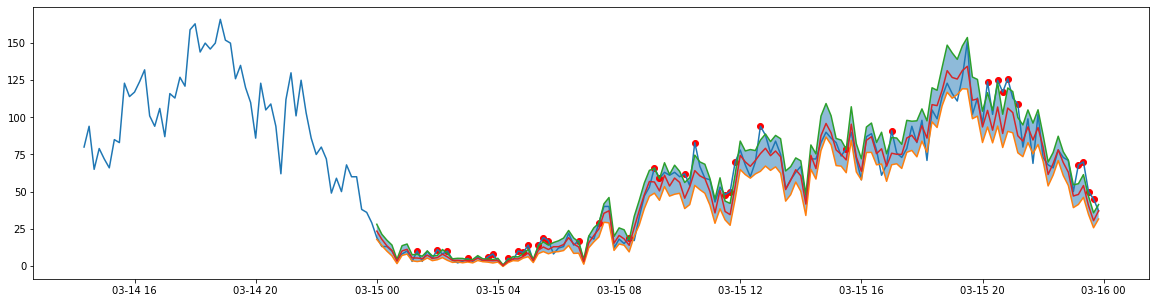

In [17]:
anomalies = full_data['2012-03-15 00:00:00':][full_data['2012-03-15 00:00:00':].values-prediction['0.9'].values > 0]

plt.figure(figsize=(20,5))
plt.plot(full_data['2012-03-14 14:20:00':])
plt.plot(prediction)
plt.fill_between(prediction.index, prediction['0.9'],prediction['0.1'], alpha=0.5)
plt.scatter(anomalies.index, anomalies.values, color='red')

plt.show()

You can aggregate values to smooth out the noisy result.

In [18]:
resample_prediction = prediction.resample('2H').sum()
resample_full_data = full_data['2012-03-13 23:20:00':].resample('2H').sum()

The following figure is the result of resampling the prediction results from 10 minutes to 2 hours. Depending on the business case, the forecasting unit may be different from the one used in the training. If you resample them with larger units of time, the prediction results will be smoother. This kind of manipulation can be used to prevent too much frequent noise alarms when setting the upper/lower monitoring limit with the prediction range of time series.

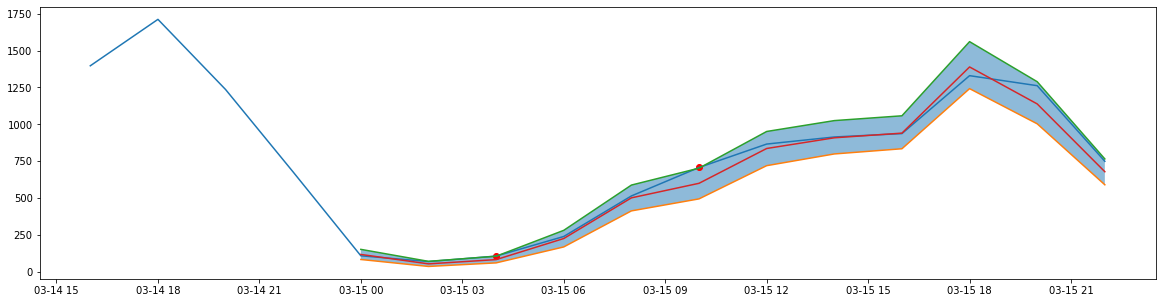

In [19]:
resample_anomalies = resample_full_data['2012-03-15 00:00:00':][resample_full_data['2012-03-15 00:00:00':].values-resample_prediction['0.9'].values > 0]

plt.figure(figsize=(20,5))
plt.plot(resample_full_data['2012-03-14 14:20:00':])
plt.plot(resample_prediction)
plt.fill_between(resample_prediction.index, resample_prediction['0.9'],resample_prediction['0.1'], alpha=0.5)
plt.scatter(resample_anomalies.index, resample_anomalies.values, color='red')

plt.show()

## Stop and Delete the Endpoint

Finally, we should delete the endpoint before we close the notebook.

To do so execute the cell below. Alternately, you can navigate to the "Endpoints" tab in the SageMaker console, select the endpoint with the name stored in the variable endpoint_name, and select "Delete" from the "Actions" dropdown menu.

In [20]:
sagemaker.Session().delete_endpoint(predictor.endpoint)